In [1]:
# 범주형 데이터를 그대로 적용하여 학습 + randomized_search(cb 자체)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier , Pool
from scipy.stats import randint, uniform
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc

In [9]:
df = pd.read_csv('../data/okcupid_preprocessed_revised.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  59934 non-null  int64  
 1   sex                         59934 non-null  int64  
 2   drinks                      59934 non-null  float64
 3   drugs                       59934 non-null  int64  
 4   education                   51629 non-null  float64
 5   height                      59934 non-null  float64
 6   job                         51739 non-null  object 
 7   last_online                 59934 non-null  object 
 8   smokes                      59934 non-null  float64
 9   Response rate               59934 non-null  float64
 10  age                         59934 non-null  int64  
 11  diet                        59934 non-null  int64  
 12  total_essay_len             59934 non-null  int64  
 13  essay_answered_count        599

In [10]:
df["last_online_dt"] = pd.to_datetime(df["last_online"])
ref_date = df["last_online_dt"].max() # 마지막 관측 시간

# churn 정의
THRESHOLD_DAYS = 30
df["inactive_days"] = (ref_date - df["last_online_dt"]).dt.days
df["churn"] = (df["inactive_days"] >= THRESHOLD_DAYS).astype(int)

print("ref_date:", ref_date)
print("churn rate:", df["churn"].mean())

ref_date: 2012-07-01 00:00:00
churn rate: 0.259235158674542


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Unnamed: 0                  59934 non-null  int64         
 1   sex                         59934 non-null  int64         
 2   drinks                      59934 non-null  float64       
 3   drugs                       59934 non-null  int64         
 4   education                   51629 non-null  float64       
 5   height                      59934 non-null  float64       
 6   job                         51739 non-null  object        
 7   last_online                 59934 non-null  object        
 8   smokes                      59934 non-null  float64       
 9   Response rate               59934 non-null  float64       
 10  age                         59934 non-null  int64         
 11  diet                        59934 non-null  int64     

In [11]:
# X 데이터 정리
drop_cols = [
    "ethnicity_black", "ethnicity_hispanic / latin", "ethnicity_mixed", "ethnicity_other","ethnicity_white",
    "dogs_encoding", "cats_encoding", "location_group_north_bay", "location_group_outside", "location_group_sf",
    "location_group_south_bay", "sign_1", "last_online", "job", "Unnamed: 0", "stability_index"
]

drop_list = []

for col in drop_cols:
    if col in df.columns:
        drop_list.append(col)

X = df.drop(columns=drop_list)

# 라벨 데이터
y = df["churn"]

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59934 entries, 0 to 59933
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   sex                   59934 non-null  int64         
 1   drinks                59934 non-null  float64       
 2   drugs                 59934 non-null  int64         
 3   education             51629 non-null  float64       
 4   height                59934 non-null  float64       
 5   smokes                59934 non-null  float64       
 6   Response rate         59934 non-null  float64       
 7   age                   59934 non-null  int64         
 8   diet                  59934 non-null  int64         
 9   total_essay_len       59934 non-null  int64         
 10  essay_answered_count  59934 non-null  int64         
 11  is_churned            59934 non-null  int64         
 12  orientation_1         59934 non-null  bool          
 13  job_score       

In [13]:
X= X.drop(columns="inactive_days")


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [16]:
train_pool = Pool(X_train, y_train)

cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=0,
    verbose=0,
    iterations=800,
    od_type="Iter",
    od_wait=60,
    auto_class_weights="Balanced",
    depth=5,
    learning_rate=0.045, 
    l2_leaf_reg=1.85,
    rsm=0.65,
    random_strength=0,
    bagging_temperature=0.2
)

cb.fit(X_train, y_train)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=0, stratify=y_train_full
)

In [9]:
obj = ['body_type', 'drinks', 'religion','smokes', 'diet', 'ethnicity', 'job_group']

In [10]:
# train_pool = Pool(
#     X_train,
#     y_train,
#     cat_features=obj
# )

# test_pool = Pool(
#     X_test,
#     y_test,
#     cat_features=obj
# )


train_pool = Pool(X_train, y_train, cat_features=obj)
valid_pool = Pool(X_valid, y_valid, cat_features=obj)
test_pool  = Pool(X_test,  y_test,  cat_features=obj)

# cb = CatBoostClassifier(
#     loss_function="Logloss",
#     eval_metric="AUC",
#     random_seed=0,
#     verbose=0,
#     iterations=800,
#     depth=6,
#     random_strength=0,
#     bagging_temperature=0.2
# )

# params = {
#     "learning_rate": np.linspace(0.03, 0.07, 7),
#     "l2_leaf_reg": np.linspace(1, 4, 6),
#     "rsm": np.linspace(0.55, 0.75, 5),
# }

# cb.randomized_search(params, X=train_pool, cv=2, n_iter=3, search_by_train_test_split=False, shuffle=True, stratified=True, verbose=True)

In [11]:
cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=0,
    verbose=0,
    iterations=800,
    od_type="Iter",
    od_wait=60,
    auto_class_weights="Balanced",
    depth=5,
    learning_rate=0.045, 
    l2_leaf_reg=1.85,
    rsm=0.65,
    random_strength=0,
    bagging_temperature=0.2
)

# params = {
#     "depth": randint(4, 9),
#     "learning_rate": np.linspace(0.05, 0.15, 25),
#     "l2_leaf_reg": np.logspace(0, np.log10(50), 20),
#     "rsm": np.linspace(0.6, 1.0, 9),
#     "random_strength": np.linspace(0, 2, 9),
#     "bagging_temperature": np.linspace(0, 1, 6),
# }

# cb.randomized_search(params, X=train_pool, cv=3, n_iter=5, search_by_train_test_split=False, shuffle=True, stratified=True, verbose=True, plot=False)

In [12]:
cb.get_params()
print(f"best_params: {cb.get_params()}") 

best_params: {'iterations': 800, 'learning_rate': 0.045, 'depth': 5, 'l2_leaf_reg': 1.85, 'rsm': 0.65, 'loss_function': 'Logloss', 'od_wait': 60, 'od_type': 'Iter', 'random_seed': 0, 'verbose': 0, 'auto_class_weights': 'Balanced', 'random_strength': 0, 'eval_metric': 'AUC', 'bagging_temperature': 0.2}


In [13]:
cb.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=60,)

In [14]:
proba = cb.predict_proba(test_pool)[:, 1]

thresholds = np.linspace(0.05, 0.95, 91)
best_thres = None
best_f1 = -1

for t in thresholds:
    pred_t = (proba >= t).astype(int)
    f1 = f1_score(y_test, pred_t, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_thres = t
        
print("best threshold:", best_thres, "best F1:", best_f1)
pred_best = (proba >= best_thres).astype(int)
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, pred_best, zero_division=0))

best threshold: 0.4599999999999999 best F1: 0.44562260202302056
ROC-AUC: 0.6427664416186193
              precision    recall  f1-score   support

           0       0.82      0.51      0.63     13320
           1       0.33      0.69      0.45      4661

    accuracy                           0.56     17981
   macro avg       0.58      0.60      0.54     17981
weighted avg       0.70      0.56      0.58     17981



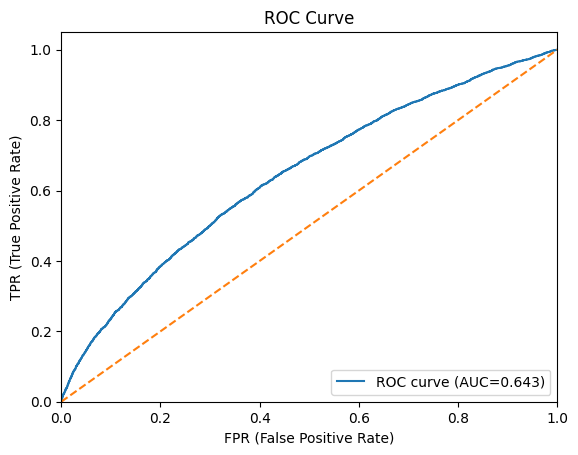

In [15]:
fpr, tpr, th = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC={roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [16]:
import joblib

joblib.dump(cb, "../models/catboost_model_enc.pkl")

['../models/catboost_model_enc.pkl']